In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from faker import Faker

### Goal:
Create and evaluate a machine learning binary classification model that predicts whether a given client will default on a loan based on the provided features in a dataset from Kaggle named Loan Default prediction. The data processing, analysis, and modeling are performed in Python.

| Feature Name     | Description                              |
|------------------|------------------------------------------|
| LoanID           | A unique identifier for each loan        |
| Age              | The age of the borrower                   |
| Income           | The annual income of the borrower        |
| LoanAmount       | The amount of money being borrowed       |
| CreditScore      | The credit score of the borrower          |
| MonthsEmployed   | The number of months the borrower has been employed |
| NumCreditLines  | The number of credit lines the borrower has open |
| InterestRate    | The interest rate for the loan            |
| LoanTerm        | The term length of the loan in months     |
| DTIRatio        | The Debt-to-Income ratio                  |
| Education       | The highest level of education attained by the borrower |
| EmploymentType  | The type of employment status of the borrower |
| MaritalStatus   | The marital status of the borrower        |
| HasMortgage    | Whether the borrower has a mortgage       |
| HasDependents  | Whether the borrower has dependents       |
| LoanPurpose    | The purpose of the loan                    |
| HasCoSigner   | Whether the loan has a co-signer           |
| Default       | Indicate whether the loan defaulted or not|


In [2]:
df = pd.read_csv('loan_default.csv')

### Data exploration

In [3]:
df.head(10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
5,A9S62RQ7US,25,90298,90448,720,18,2,22.72,24,0.10,High School,Unemployed,Single,Yes,No,Business,Yes,1
6,H8GXPAOS71,38,111188,177025,429,80,1,19.11,12,0.16,Bachelor's,Unemployed,Single,Yes,No,Home,Yes,0
7,0HGZQKJ36W,56,126802,155511,531,67,4,8.15,60,0.43,PhD,Full-time,Married,No,No,Home,Yes,0
8,1R0N3LGNRJ,36,42053,92357,827,83,1,23.94,48,0.20,Bachelor's,Self-employed,Divorced,Yes,No,Education,No,1
9,CM9L1GTT2P,40,132784,228510,480,114,4,9.09,48,0.33,High School,Self-employed,Married,Yes,No,Other,Yes,0


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [5]:
print(df['Default'].value_counts())

# Goods: 21628
# Bads: 8372

0    225694
1     29653
Name: Default, dtype: int64


### Feature engineering

In [6]:
# Debt-to-Income Ratio t oadd predictive value to loan default or credit risk
df['debt_to_income_ratio'] = df['LoanAmount'] / df['Income']
# Handle zero division if customers have declared zero income
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].replace([np.inf, -np.inf], np.nan)

### Data Audit

In [7]:
def data_audit(df):
    """
    Perform a comprehensive data audit of a pandas DataFrame.
    
    This function computes and returns key statistics for each column including:
    - Data types
    - Non-null counts
    - Null counts and percentages
    - Descriptive statistics (mean, std, min, max) for numeric columns
    - Unique value counts for all columns

    Returns pandas.DataFrame, Summary statistics and data quality indicators for each column in `df`.
    """
    # Save original pandas float format option
    orig_float_format = pd.options.display.float_format
    # Set float format to 4 decimals for readable output
    pd.options.display.float_format = '{:.4f}'.format

    audit_df = pd.DataFrame()
    audit_df['Data Type'] = df.dtypes
    audit_df['Non-Null Count'] = df.notnull().sum()
    audit_df['Null Count'] = df.isnull().sum()
    audit_df['Null Percentage'] = 100 * df.isnull().mean()
    
    # Summary statistics for numeric columns
    stats = df.describe().T
    audit_df = audit_df.join(stats[['mean', 'std', 'min', 'max']], how='left')
    
    # For categorical or object columns, add unique counts
    audit_df['Unique Values'] = df.nunique()
    
    # Restore original float format after operation (optional)
    pd.options.display.float_format = orig_float_format

    return audit_df


audit_report = data_audit(df)
print(audit_report)

                     Data Type  Non-Null Count  Null Count  Null Percentage  \
LoanID                  object          255347           0              0.0   
Age                      int64          255347           0              0.0   
Income                   int64          255347           0              0.0   
LoanAmount               int64          255347           0              0.0   
CreditScore              int64          255347           0              0.0   
MonthsEmployed           int64          255347           0              0.0   
NumCreditLines           int64          255347           0              0.0   
InterestRate           float64          255347           0              0.0   
LoanTerm                 int64          255347           0              0.0   
DTIRatio               float64          255347           0              0.0   
Education               object          255347           0              0.0   
EmploymentType          object          255347      

Default (target) distribution:
0    225694
1     29653
Name: Default, dtype: int64


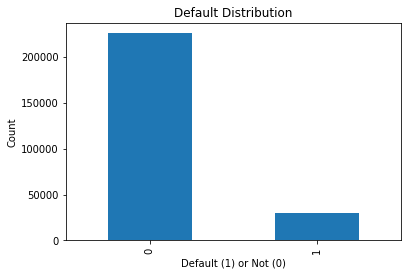

In [8]:
# Target distribution
print("Default (target) distribution:")
print(df['Default'].value_counts())
df['Default'].value_counts().plot(kind='bar')
plt.title('Default Distribution')
plt.xlabel('Default (1) or Not (0)')
plt.ylabel('Count')
plt.show()

### Data Prep

In [9]:
print("Original dataset size:", df.shape)

df = df.drop(columns=['LoanID'])

# Remove duplicate rows based on all columns
df = df.drop_duplicates(keep='first', ignore_index=True)

print("Dataset size after deduplication:", df.shape)

# No duplicated rows

Original dataset size: (255347, 19)
Dataset size after deduplication: (255347, 18)


In [10]:
# Drop target from features
X = df.drop(columns=['Default'])  
y = df['Default']

In [11]:
# Separate categorical and numerical columns
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(cat_features,"\n ---------------- \n", num_features)

['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'] 
 ---------------- 
 ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'debt_to_income_ratio']


In [12]:
# Numerical data: only scale
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical data: only one-hot encode (no imputation needed)
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

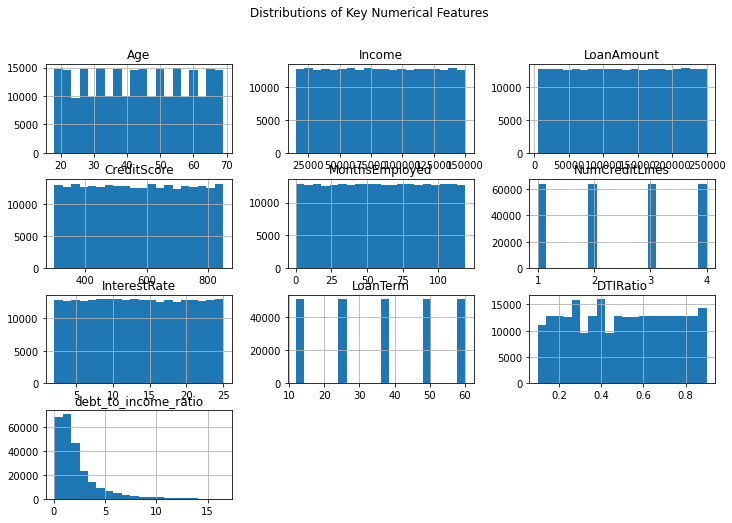

In [13]:
#Histogram of numerical columns
df[num_features].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distributions of Key Numerical Features')
plt.show()

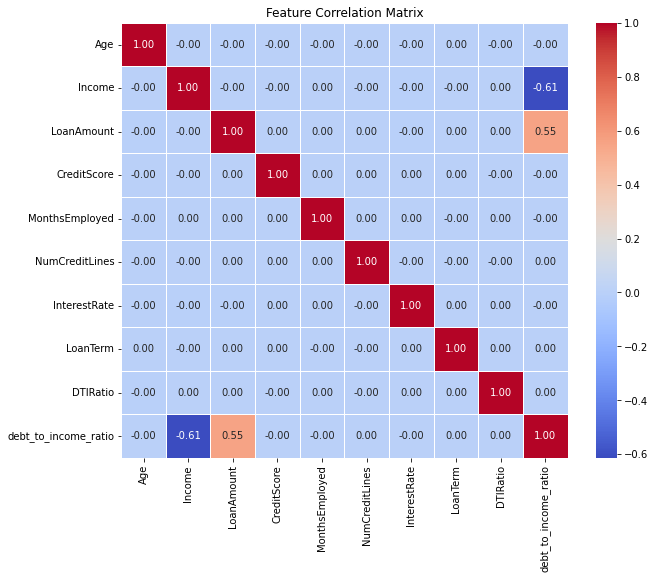

In [14]:
# Corrrelation Matrix
corr_matrix = X.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

Higher correlation is seen only for the variables associated with the engineered feature of debt to income ratio.

In [15]:
#Outlier detection on numerical features
out_liars = df[num_features]


iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['outlier'] = iso_forest.fit_predict(out_liars)

print(f"Detected outliers: {sum(df['outlier'] == -1)}")

Detected outliers: 12768


In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Hyperparameter tuning

In [17]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [18]:
# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': ['balanced', None]
}
# balanced option to compensate for unbalanced training data by weighting classes inversely to their frequency

In [19]:
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=3,
    scoring='roc_auc'
)

In [20]:
grid_search.fit(X_train, y_train)
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"Best ROC AUC: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found by GridSearchCV:
{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best ROC AUC: 0.7489


### Modeling

In [21]:
best_estimator = grid_search.best_estimator_

In [22]:
print(best_estimator)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount', 'CreditScore',
                                                   'MonthsEmployed',
                                                   'NumCreditLines',
                                                   'InterestRate', 'LoanTerm',
                                                   'DTIRatio',
                                                   'debt_to_income_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))

### Predict and evaluate

In [23]:
y_pred = best_estimator.predict(X_test)
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84     45139
           1       0.25      0.63      0.36      5931

    accuracy                           0.74     51070
   macro avg       0.59      0.69      0.60     51070
weighted avg       0.86      0.74      0.78     51070



The model identifyies well the goods, with high precision and recall.

Bads are not identified well

In [25]:
counts = np.bincount(best_estimator.predict(X_test))
df_counts = pd.DataFrame(counts, index=['goods', 'bads'], columns=['Prediction_Count'])
print(df_counts)

       Prediction_Count
goods             36153
bads              14917


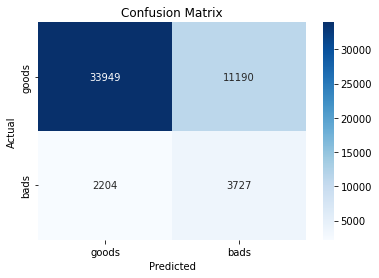

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame with custom row and column labels
cm_df = pd.DataFrame(cm, index=['goods', 'bads'], columns=['goods', 'bads'])

sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

True Negatives: The model correctly predicted 4195 actual goods as goods.

False Positive: The model incorrectly predicted 11190 actual goods as bads.

False Negatives: The model incorrectly predicted 2204 actual bads as goods.

True Positives: The model correctly predicted 3727 actual bads as bads.


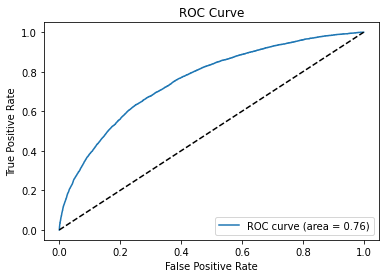

In [27]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

AUC of 0.76 indicates the model performs substantially better than random, correctly ranking positive cases higher than negative ones about 76% of the time.

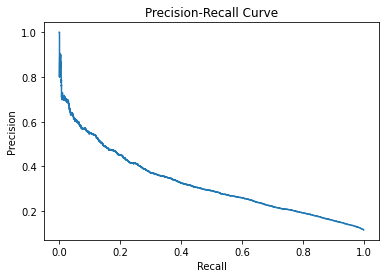

In [28]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

PR plots precision (the accuracy of bads predictions) on the y-axis against recall (the ability to find all bads cases) on the x-axis across different decision thresholds.
Increasing recall decreases precision, as capturing more bads may also bring more false positives (bads).
The PR curve shows that the model predicts the bads well.

### Feature importance

In [29]:
# Extract feature names after one-hot encoding
feature_names_num = num_features
feature_names_cat = best_estimator.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

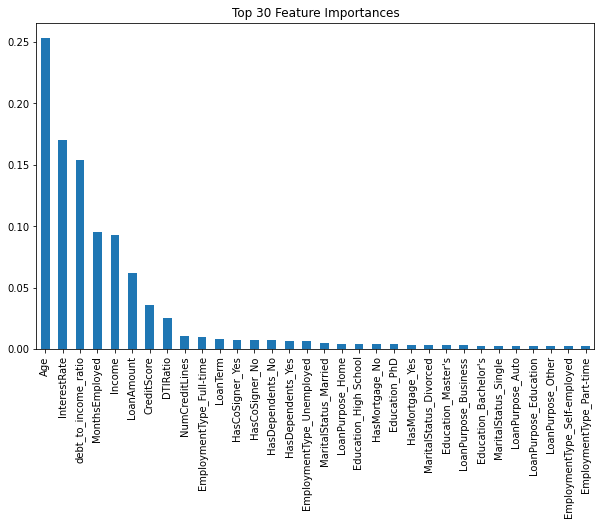

In [30]:
importances = best_estimator.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(42).plot(kind='bar')
plt.title('Top 30 Feature Importances')
plt.show()

Fit an XGBoost classifier on the selected features with max importance

In [31]:
preprocessor = best_estimator.named_steps['preprocessor']
print(preprocessor.transformers_)

[('num', Pipeline(steps=[('scaler', StandardScaler())]), ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'debt_to_income_ratio']), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'])]


In [36]:
def get_feature_names(column_transformer):
    # list to hold all feature names
    feature_names = []
    
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop':
            continue
        if transformer == 'passthrough':
            # If 'passthrough', columns are passed as they are
            feature_names.extend(columns)
        else:
            try:
                names = transformer.get_feature_names_out(columns)
            except AttributeError:
                # fallback if transformer does not support get_feature_names_out
                names = columns
            feature_names.extend(names)
    return feature_names

all_features = get_feature_names(preprocessor)

# Transform X
X_transformed = preprocessor.transform(X)

if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

X_transformed_df = pd.DataFrame(X_transformed, columns=all_features)

# Continue with feature importances as before
importances = best_estimator.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)
top_features = feat_imp.head(25).index.tolist()

X_top = X_transformed_df[top_features]

# Split and train new model on these selected features
X_train, X_test, y_train, y_test = train_test_split(X_top, y, stratify=y, test_size=0.2, random_state=42)



In [37]:
model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.60      0.07      0.12      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.53      0.53     51070
weighted avg       0.86      0.89      0.84     51070



### Additional Analysis
Learning Curves:
Show training and validation performance as a function of training data size or epochs to diagnose bias/variance issues.

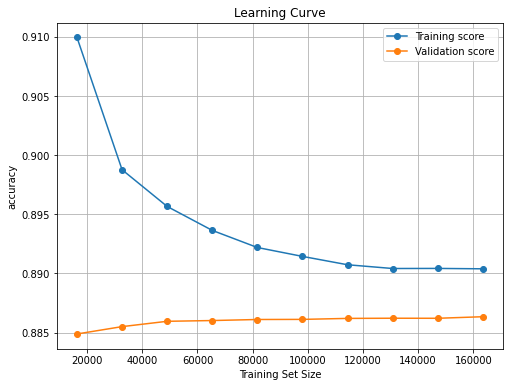

In [35]:
def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', marker='o')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score', marker='o')
    plt.xlabel('Training Set Size')
    plt.ylabel(scoring)
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(model, X_train, y_train)

The plot shows high training score and much lower validation score (big gap) which indicates overfitting — the model memorizes training data but generalizes poorly.

### TODO

Cross-validation - display distributions of performance metrics from cross-validation runs to assess model stability.
Use a logistic regression mode